In [ ]:
#
# This notebook is for the exploration of Linear Regression -- it corresponds to Lecture Handout 1
#

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/4c16-labs/code/lab-01/


Mounted at /content/drive
/content/drive/MyDrive/4c16-labs/code/lab-01


In [2]:
# Autoload setup (you don't need to edit this cell); instructions to: 
#   i) enable autoreloading of modules
%load_ext autoreload
#  ii) import the module 'lab_1' (which will contain your functions) in an autoreloadable way 
%aimport lab_1
# iii) indicate that we want autoreloading to happen on every evaluation.
%autoreload 1

In [3]:
%%javascript
// This cell disables scrollbars on our output, which is handier when we want to do lots of plots.
// Don't edit this cell!
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
# Global setup (you don't need to edit this cell): make the modules we want available in the notebook.
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# Plot setup (you don't need to edit this cell): configure the default plot style to be clear & pleasing.
plt.style.use('bmh')
plt.style.use('ggplot')
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.7

# One other thing: disable scientific notation when displaying numpy matrices.  If you prefer scientific notation,
# comment out this line.
np.set_printoptions(formatter={'float': '{: 0.6f}'.format})

In [6]:
# Useful functions for playing with linear regression.
# DON'T EDIT THIS CELL!

# Generates noisy data from a polynomial model.
# Points are in the range -10 .. 10.
#
# w = polynomial weights (np.array, first element is 0th power)
# n = number of data points to generate.
# sigma = std. deviation of (zero-mean Gaussian) noise to add.
def generate_data(w, n, sigma):
    p = w.size-1;
    x = (np.random.rand(n,1) - 0.5)*20;  # uniform over range -10 .. 10
    X = lab_1.polynomial_design_matrix(x, order=p);
    y = np.matmul(X, w) + np.random.randn(n,1)*sigma;
    return x,y;

# Generates predicted values for the input values 'x', using
# the polynomial model 'w'.
def predict(x, w):
    poly_order = w.size-1;
    X = lab_1.polynomial_design_matrix(x, order=poly_order);
    y = np.matmul(X,w);
    return y;

# Plots a polynomial fit:
#
# x: input values (x-axis locations)
# y: output values (y-axis locations corresponding to x)
# w: polynomial coefficients: putative fit to evaluate
# w0: polynomial coefficients: the true, underlying polynomial
def plot_polynomial_fit(x, y, w, w0):
    u = np.arange(-10, 10, .2); 
    v = predict(u, w);
    v0 = predict(u, w0);

    plt.axis((-10,10,-10,100))
    plt.plot(x, y, 'o', label="input data")
    plt.plot(u, v, '-', label="polynomial fit")
    plt.plot(u, v0, '--', label="Ground Truth")
    plt.ylabel('y')
    plt.xlabel('x')
    plt.legend()
    plt.show()

In [13]:
# EXERCISE: The 'polynomial design matrix' cell
#
# Your first exercise is to implement the function 'polynomial_design_matrix'
# in the module file lab_1.py.  See the instructions there.  Evaluate this cell
# to call that function, to check that it's working.
#
# You should get a matrix (array of arrays) in which each row contains successive powers of each element of the input:
#
# example: print(lab_1.polynomial_design_matrix(np.array([2,4,3]), 3))
#
# [[  1.   2.   4.   8.]
#  [  1.   4.  16.  64.]
#  [  1.   3.   9.  27.]]
#
print(lab_1.polynomial_design_matrix(np.array([2,4,3]), 3))

[[ 1.000000  2.000000  4.000000  8.000000]
 [ 1.000000  4.000000  16.000000  64.000000]
 [ 1.000000  3.000000  9.000000  27.000000]]


In [14]:
# The 'true polynomial' cell (defines the underlying data generation process)
#
# Now that we have the components required for least-squares regression (in the file lab_1.py), we can experiment
# with fitting some data.  We are going to use data generated from a polynomial with added noise.

# First, we define the 'true polynomial', which we will use to generate the data.
#
# Fundamentally, this is just a question of defining a list of powers, so 
# the list [0.3, 1.3, -3, 0.1] defines the polynomial 0.3 + 1.3 * x - 3 * x^2 + 0.1 * x^3.
# To include higher powers, we just add more elements to the list.
#
# However, there are three bits of data-massage which complicate this slightly:
#   i) We use np.array to turn the python list into a Numpy array
#  ii) We use a list of list, rather than just a list, so as to make this array a 1xN matrix (row vector)
# iii) We use np.transpose to turn the row vector into a column vector, which is what we want for the matrix multiply.
true_poly = np.transpose(np.array([[0, -1, 1.3, 0]]))

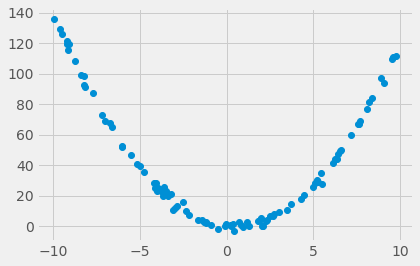

In [15]:
# The 'data generation' cell (generates data)
#
# First, fix the random number generator so that our results are repeatable.  If you comment out this
# line, you will see different data every time you run, which might be a bit more interesting.  But when
# working on a program, it's frustrating if you see some surprising result that you want to investigate,
# which you then can't reproduce because your data is changing randomly each time.  So fixing the generator
# in this way is a good practice.
np.random.seed(seed=10)  # The value 10 is arbitrary.

# Now we can generate the data, specifying how many points to generate and how much noise to add
num_data_points = 100
noise_std_dev = 2
(data_x, data_y) = generate_data(true_poly, num_data_points, noise_std_dev)

# We can have a look at the data with 'plt.plot'.
# Experiment with:
# different underlying true polynomials (edit and re-evaluate the 'true polynomial' cell, then re-evaluate this cell)
# different amounts of noise
# different numbers of points
#
plt.plot(data_x, data_y, 'o');

Fit polynomial: [[ 0.183262 -1.191156  1.298562  0.002591]]


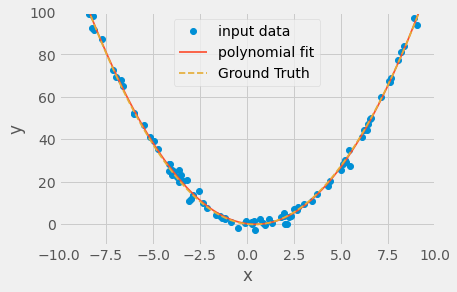

In [16]:
# The 'fitting data - least squares' cell
#
# Here we use the functions from lab_1.py to fit a polynomial to the data we have generated.
proposed_order = 3  # Order of polynomial to fit
fit_poly = lab_1.LS_poly(data_x, data_y, proposed_order)

# Now show the coefficients of the fitted polynomial. We transpose it to a row vector for neater display.
print("Fit polynomial: " + str(np.transpose(fit_poly)))   

# Plot the fit polynomial against the data (and show the true polynomial too)
plot_polynomial_fit(data_x, data_y, fit_poly, true_poly)

# Experiment now with different values for 'proposed order' against different true polynomials, 
# noise levels, & numbers of data points. Re-evaluate this cell each time to view the results.

Fit polynomial (no regularization):
[[ 99.359863  60.859375  10.359375 -14.648438 -1.759033  0.885254
   0.098545 -0.018803 -0.002132  0.000109  0.000013]]
Fit polynomial (with regularization):
[[ 0.396627 -0.026922  0.498954 -0.811958  0.243008  0.089149 -0.011193
  -0.003733  0.000053  0.000054  0.000003]]


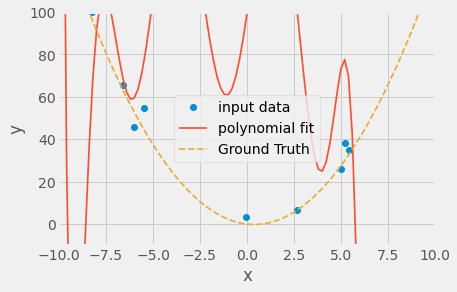

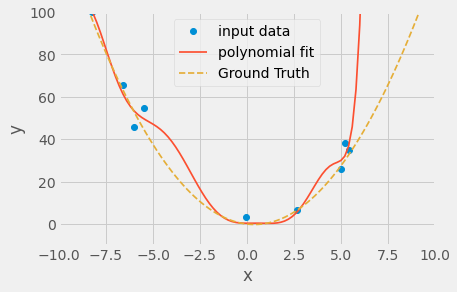

In [23]:
# EXERCISE: The 'importance of regularization' cell
#
# The exercise is to modify the 'linear_regression' function in 'lab_1.py' to include a Tikhonov regularization term.
# See lecture handout 1, slide 35.
#
# To demonstrate the effect of regularization, we will generate some noisy data and try to model it 
# using a polynomial of foolishly high order.
#
# Note that the values used here are tuned to demonstrate the effect; you are encouraged to
# change the values and experiment, but not until you've seen the effect work with the provided values!


# First we generate the data to fit.  This stuff is explained in the cells above.  Here
# of course it is obvious that we are dealing with a data generating process which is 
# a 2nd-order polynomial, but in a real application we wouldn't know the underlying process.
true_poly = np.transpose(np.array([[0, -1, 1.3]]))
np.random.seed(seed=10)
num_data_points = 10    # Number of points (10 points is not a lot)
noise_std_dev = 8       # Amount of noise (8 is moderately high)
(data_x, data_y) = generate_data(true_poly, num_data_points, noise_std_dev)

# Now we will fit polynomials, one without regularization and one with.  Note that
# these will be identical until you've done the exercise (implementing addition of epsilon).
proposed_order = 10  # Order of polynomial to fit (10 == crazy high)
epsilon = 10         # Amount of regularization (10 == a lot)
fit_poly_no_reg = lab_1.LS_poly(data_x, data_y, proposed_order)
fit_poly_with_reg = lab_1.LS_poly(data_x, data_y, proposed_order, epsilon)

# Display the coefficients of the fitted polynomials.  The regularized polynomial
# should have smaller coefficients.
print("Fit polynomial (no regularization):\n" + str(np.transpose(fit_poly_no_reg))) 
print("Fit polynomial (with regularization):\n" + str(np.transpose(fit_poly_with_reg))) 

# Plot the fit polynomials against the data.  The regularized one should be rather more sensible.
plot_polynomial_fit(data_x, data_y, fit_poly_no_reg, true_poly)
plot_polynomial_fit(data_x, data_y, fit_poly_with_reg, true_poly)


In [25]:
# EXERCISE: The 'Mean-squared-error'cell

# Exercise 3 is to implement a function 'mean_squared_error(x, y)' in your
# lab_1.py file, which computes the MSE between two vectors (slide 6 of lecture handout 1).

# Complete that now, and then evaluate this cell to check:
array_1 = np.array([1] * 10)     # A numpy array from the python list containing '1' ten times
array_2 = np.array(range(0, 10)) # A numpy array from the python list built from the range 0--9 (inclusive).
print(lab_1.mean_squared_error(array_1, array_2))  # This should print 20.5 for the MSE of [1 ten times] vs [0..9].

20.5


In [26]:
# The 'functions for MSE' cell (you don't need to edit this cell)
#
# This defines functions for evaluating the MSE resulting from a polynomial fit to some data,
# for orders 0 to 12.

# Returns the MSE of a polynomial fit of order 'order' to data (x, y)
def poly_mse(x, y, order):
    p = lab_1.LS_poly(x, y, order, 0)
    d = predict(x, p)
    return lab_1.mean_squared_error(y, d)

# Computes the MSE for polynomial fits to data (x,y) for orders 0--12 inclusive.
# Returns the MSEs in a numpy row vector (Nx1 matrix)
def mse_vs_order(x, y):
    K = 12;
    mse = np.zeros(shape=(K+1,1))
    for p in range(0, K+1):
        mse[p] = poly_mse(x, y, p);
    return mse

# Given data (x,y), plots the curve of (log) MSE vs polynomial order for the range of orders
# used in mse_vs_order.
def plot_mse_vs_order(x, y):
    log_mse = np.log(mse_vs_order(data_x, data_y));
    plt.plot(log_mse, '-')
    plt.ylabel('log(MSE) for training set')
    plt.xlabel('polynomial order')
    plt.show()

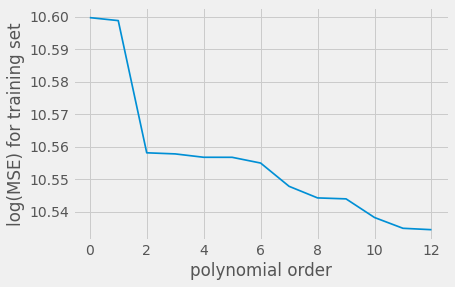

In [27]:
# The 'evaluating the MSE' cell
#
# Here we will generate some data and examine how the MSE of a polynomial fit to the data, against
# the data itself, behaves.  For the initial values in the cell, we should see more-or-less monotonic
# reduction of MSE with order.

# Generate some data (this code explained in cells above)
true_poly = np.transpose(np.array([[0, -1, 1.3, 0]]))
num_data_points = 1000    # 1000 is a pretty good amount of data in this context -- experiment with 10, 100, 10000
noise_power = 200         # 200 is a lot of noise, even for 1000 points
np.random.seed(seed=10)
(data_x, data_y) = generate_data(true_poly, num_data_points, noise_power)

# Draw the plot
plot_mse_vs_order(data_x, data_y)

# Experiment with other polynomials, more / less data, more / less noise...

In [28]:
# The 'more functions for MSE' cell (you don't need to edit this cell)
#
# This defines functions for evaluating the MSE resulting from a polynomial fit to some data,
# for orders 0 to 12.  Here two sets of data are used:
# the 'training set' (training_x, training_y) is used to fit the polynomial, i.e. compute the coefficients
# the 'test set' (test_x, test_y) is used to evaluate the fit, i.e. the MSE is computed using these.

def poly_mse_train_vs_test(training_x, training_y, test_x, test_y, order):
    p = lab_1.LS_poly(training_x, training_y, order, 0)
    d = predict(test_x, p)
    return lab_1.mean_squared_error(test_y, d)

def mse_vs_order_train_vs_test(training_x, traning_y, test_x, test_y):
    max_order = 12;
    mse = np.zeros(shape=(max_order+1,1)) # '+1' to allow for 0
    for p in range(0, max_order+1):       # '+1' as end of range is not included
        mse[p] = poly_mse_train_vs_test(training_x, training_y, test_x, test_y, p);
    return mse

def plot_mse_vs_order_train_vs_test(training_x, training_y, test_x, test_y):
    log_mse = np.log(mse_vs_order_train_vs_test(training_x, training_y, test_x, test_y));
    plt.plot(log_mse, '-')
    plt.ylabel('log(MSE) for training set')
    plt.xlabel('polynomial order')
    plt.show()

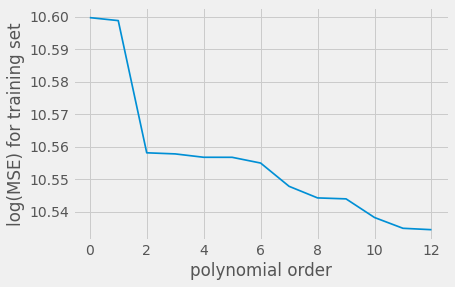

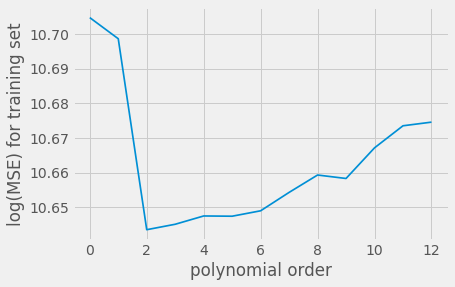

In [29]:
# The 'importance of evaluating on unseen data' cell (Lecture handout 1 slides 28-29)
#
# Here again we generate some data and look at how the MSE behaves as we model 
# this data with polynomials of various order.
#
# However, here we will fit the polynomial to one set of data but evaluate the MSE
# using another set of data from the same source.  This is crucial to checking
# if the model which we fit to our data will generalize to future observations
# of the same process.
#
# In this lab, 'from the same source' is equivalent to 'identically generated';
# I've been a bit lazy in generating the data by using two calls to 'generate_data'.
# In the real world we would have one set of data and we would partition it into a training
# set and a test set -- or, in a more elaborate scheme, multiple such sets, all to be covered
# in future labs.

# Again with the generating the data.
true_poly = np.transpose(np.array([[0, -1, 1.3, 0]]))
noise_power = 200
num_training_data_points = 1000
num_test_data_points = 1000

np.random.seed(seed=10)
(training_x, training_y) = generate_data(true_poly, num_training_data_points, noise_power)
(test_x, test_y) = generate_data(true_poly, num_test_data_points, noise_power)

# Now we plot MSE vs order: first using the same set for fitting & evaluation...
plot_mse_vs_order_train_vs_test(training_x, training_y, training_x, training_y)
# ... and second using a separate set for evaluation.
plot_mse_vs_order_train_vs_test(training_x, training_y, test_x, test_y)

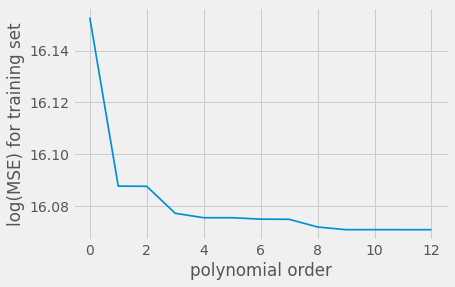

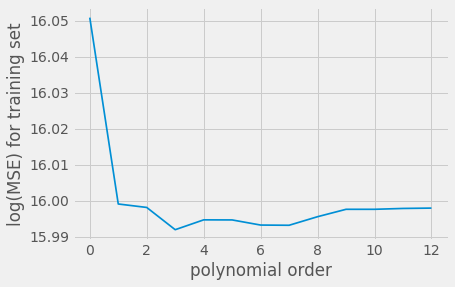

In [30]:
# Exercise 4: just to confirm your understanding
#
# Change the function 'question_4' to return the best order for a
# polynomial fit to this data:

# Load the data
data = np.loadtxt('lab_1.data', delimiter=',')

# Split it into two equal sets, for training and test.
num_points = data.shape[1]
set_size = num_points //  2
training_x = data[0,0:set_size]
training_y = data[1,0:set_size]
test_x = data[0,set_size:]
test_y = data[1,set_size:]

# Now plot MSE vs order: first using the same set for fitting & evaluation...
plot_mse_vs_order_train_vs_test(training_x, training_y, training_x, training_y)
# ... and second using a separate set for evaluation.
plot_mse_vs_order_train_vs_test(training_x, training_y, test_x, test_y)

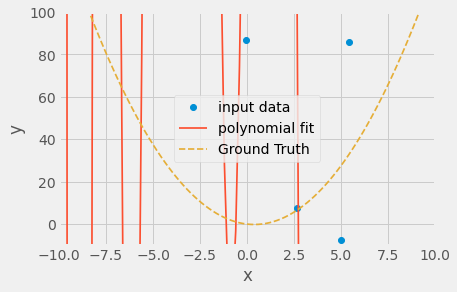

Fit polynomial (no regularization):
[[ 328.377930  755.656250  222.132812 -215.476562 -29.939453  11.197754
   1.211502 -0.136108 -0.007935 -0.000904 -0.000311 -0.000001  0.000002]]




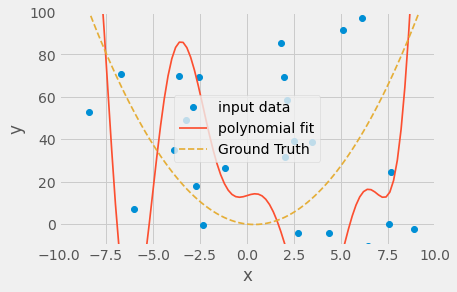

Fit polynomial (no regularization):
[[ 13.429595  2.887966  0.228659 -5.441428  0.210911  0.423858 -0.021867
  -0.011638  0.000667  0.000134 -0.000008 -0.000001  0.000000]]




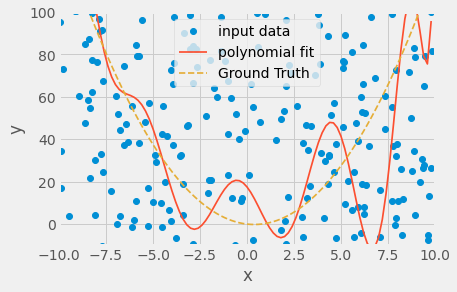

Fit polynomial (no regularization):
[[ 17.527472 -11.187448 -8.822241  2.780406  1.282090 -0.171342 -0.059450
   0.004019  0.001213 -0.000040 -0.000011  0.000000  0.000000]]




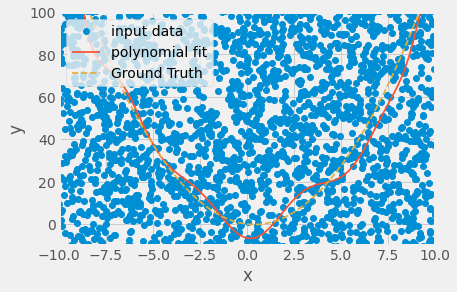

Fit polynomial (no regularization):
[[-6.602014 -1.925479  5.148705  0.321135 -0.400906 -0.024751  0.016598
   0.000666 -0.000328 -0.000007  0.000003  0.000000 -0.000000]]




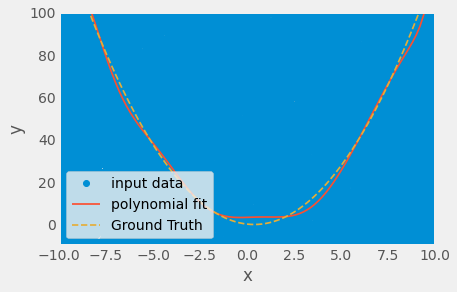

Fit polynomial (no regularization):
[[ 3.181833  0.265123  0.129628 -0.353560  0.108933  0.020607 -0.004559
  -0.000457  0.000093  0.000004 -0.000001 -0.000000  0.000000]]




In [31]:
# The Final Cell: observe how more data protects from overfitting

# Our friend the polynomial, old and true.
true_poly = np.transpose(np.array([[0, -1, 1.3, 0]]))

# Lots of noise:
noise_power = 200

proposed_order = 12  # Order of polynomial to fit (12 == crazy high)

np.random.seed(seed=10)  # Repeatable results

for amount_of_data_log_10 in range(1,6):
    # Each time through the loop we get 10x the data, so 10; 100; 1000; 10,000; 100,000.
    num_data_points = 10**amount_of_data_log_10
    (data_x, data_y) = generate_data(true_poly, num_data_points, noise_power)
    fit_poly_no_reg = lab_1.LS_poly(data_x, data_y, proposed_order)
    plot_polynomial_fit(data_x, data_y, fit_poly_no_reg, true_poly)
    print("Fit polynomial (no regularization):\n" + str(np.transpose(fit_poly_no_reg)))
    print("\n")  # Just to space out the results a bit.
    
# Notice how with more data the fits become more sensible (less wobbly).  The same effect
# can be seen in the numerical coefficients: the higher-power coefficients go towards 0
# as the data increases.